## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install odc-geo --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster
from coastlines.raster import model_tides, multiprocess_apply
from intertidal.extents import load_data, pixel_tide_sort, item, nidem


def create_dask_gateway_cluster(profile="r5_L", workers=2):
    """
    Create a cluster in our internal dask cluster.
    Parameters
    ----------
    profile : str
        Possible values are:
            - r5_L (2 cores, 15GB memory)
            - r5_XL (4 cores, 31GB memory)
            - r5_2XL (8 cores, 63GB memory)
            - r5_4XL (16 cores, 127GB memory)
    workers : int
        Number of workers in the cluster.
    """        
    
    try:
        
        from dask_gateway import Gateway
        gateway = Gateway()

        # Close any existing clusters
        if len(cluster_names) > 0:
            print("Cluster(s) still running:", cluster_names)
            for n in cluster_names:
                cluster = gateway.connect(n.name)
                cluster.shutdown()

        # Connect to new cluster
        options = gateway.cluster_options()
        options["profile"] = profile
        options["jupyterhub_user"] = "robbi"
        cluster = gateway.new_cluster(options)
        cluster.scale(workers)

        return cluster

    except ClientConnectionError:
        raise ConnectionError("Access to dask gateway cluster unauthorized")

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-intertidal/dask-worker-space/worker-b69ejxw0', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44769,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:42691,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/35035/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:41175,


## Setup

In [5]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [ ]:
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
# aoi = 'Seven Emu'
aoi = 'Wollogorang'

# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [6]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Load data

In [7]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=('2019', '2021'), 
               resolution=10)
ds

<xarray.Dataset>
Dimensions:      (time: 315, y: 1214, x: 1974)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T00:59:08.684254 ... 2021-12...
  * y            (y) float64 8.277e+06 8.277e+06 ... 8.265e+06 8.265e+06
  * x            (x) float64 6.4e+05 6.4e+05 6.4e+05 ... 6.597e+05 6.598e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 1214, 1974), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides

In [8]:
# Create a new 5km-res tide modelling grid after first
# buffering the grid by 12km (i.e. at least two 5km pixels)
rescaled_geobox = ds.odc.geobox.buffered(12000).zoom_out(500)
rescaled_ds = odc.geo.xr.xr_zeros(rescaled_geobox)

# Flatten grid to 1D, then add time dimension
flattened_ds = rescaled_ds.stack(z=("x", "y"))
flattened_ds = flattened_ds.expand_dims(dim={"time": ds.coords["time"].values})

In [9]:
# Model tides for each time and grid cell
tide_df = model_tides(
    x=flattened_ds.x,
    y=flattened_ds.y,
    time=flattened_ds.time,
    directory="~/tide_models",
    epsg=ds.odc.geobox.crs.epsg,
)

In [10]:
# Insert modelled tide values back into flattened array, then unstack
# back to 3D (x, y, time)
tides_ds = (
    flattened_ds.groupby("time")
    .apply(lambda x: tide_df.loc[str(x.time.values)].tide_m.values)
    .astype(np.float32)
    .unstack("z")
    .T
)

In [11]:
# Reproject each timestep into higher resolution, and add as new variable
def timestep_reproject(x, to_geobox=ds.odc.geobox):
    return x.odc.reproject(to_geobox, resampling='cubic')

ds['tide_m'] = multiprocess_apply(tides_ds, dim='time', func=timestep_reproject)


<AxesSubplot:title={'center':'time = 2019-01-06T01:11:32.919000, spatial_ref ...'}, xlabel='x', ylabel='y'>

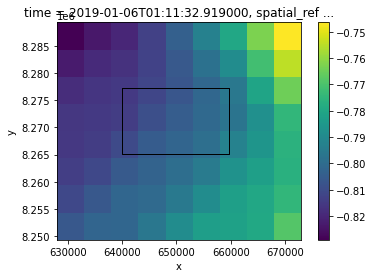

In [12]:
timestep = tides_ds.isel(time=1)
timestep.plot()
gpd.GeoSeries(ds.odc.geobox.footprint(crs='EPSG:32753').geom).plot(ax=plt.gca(), vmin=timestep.min(), vmax=timestep.max(), color='none')

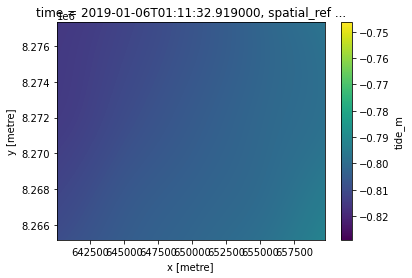

In [13]:
ds['tide_m'].isel(time=1).plot.imshow(vmin=timestep.min(), vmax=timestep.max())

## ITEM/NIDEM method

In [ ]:
# intervals=10

# # Add tide height dimension
# ds_item = ds.copy()
# ds_item['tide_height'] = ds_item.tide_m.mean(dim=['x', 'y'])
# ds_item = ds_item.swap_dims({"time": "tide_height"}).drop("time")

In [ ]:
# # Calculate intertidal extents
# ds_item.persist()
# item_da, ds_intervals, ds_confidence = item(ds_item, tide_dim='tide_height', intervals=intervals)
# item_da.plot.imshow(cmap='RdYlBu_r', size=6)

In [ ]:
# # Convert ITEM to NIDEM elevations
# intertidal_dem_clean = nidem(item_da, ds_intervals, intervals)
# intertidal_dem_clean.plot.imshow(cmap='viridis', size=6)

In [ ]:
# # fname = 'testing'
# fname = aoi.lower().replace(" ", "")

# # Export as a GeoTIFF
# intertidal_dem_clean.odc.write_cog(
#     fname=f"data/interim/nidem_dem_{fname}.tif", overwrite=True
# )
# ds_confidence.ndwi.odc.write_cog(
#     fname=f"data/interim/nidem_confidence_{fname}.tif", overwrite=True
# )

## Pixel-based

### Special sorting

In [14]:
# Load into memory
ds.load()

<xarray.Dataset>
Dimensions:      (time: 315, y: 1214, x: 1974)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T00:59:08.684254 ... 2021-12...
  * y            (y) float64 8.277e+06 8.277e+06 ... 8.265e+06 8.265e+06
  * x            (x) float64 6.4e+05 6.4e+05 6.4e+05 ... 6.597e+05 6.598e+05
    spatial_ref  int32 32753
Data variables:
    ndwi         (time, y, x) float32 nan nan nan nan ... 0.3118 0.34 0.342
    tide_m       (time, y, x) float32 0.1595 0.1595 0.1595 ... 0.1295 0.1295
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [16]:
ds = ds.rename({'time': 'tide_n'})

In [ ]:
# Sort each pixel by tide
ds = pixel_tide_sort(ds, tide_var='tide_m', ndwi_var='ndwi', tide_dim='tide_n')
ds.isel(tide_n=[5, -5]).ndwi.plot.imshow(col='tide_n', vmin=-0.25, vmax=0.25)

### Rolling median

In [ ]:
# ds_rolling = ds.ndwi.rolling(tide_n=100, min_periods=10, center=True)
# s2_median = ds_rolling.median()
# s2_stdev = ds_rolling.std()
# s2_stdev_mean = s2_stdev.mean(dim='tide_n')

### Test pixel-wise rolling median

In [17]:
freq = (ds.ndwi > 0).where(~ds.ndwi.isnull()).mean(dim='tide_n')
good_mask = ((freq > 0.01) & (freq < 0.99))

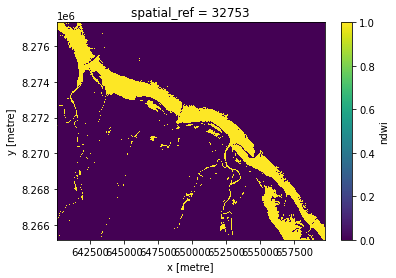

In [18]:
good_mask.plot()

In [19]:
# Mask to only good pixels, stack to 1D, then drop obs without data
ds_flat = ds.where(good_mask).stack(z=("x", "y")).dropna(dim='z', how='all')


In [20]:
intervals = 100
max_tide = ds_flat.tide_m.max(dim='tide_n')
min_tide = ds_flat.tide_m.min(dim='tide_n')
range_tide = max_tide - min_tide
interval_tide = range_tide / intervals
interval_window = range_tide / 10  # (currently underestimating)

In [21]:
import multiprocessing

def rolling_tide_window(i, ds=ds_flat, interval_tide=interval_tide, interval_window=interval_window):
    
    # Set min and max thresholds to filter dataset
    thresh_min = (min_tide + (i * interval_tide)) - interval_window
    thresh_max = (min_tide + (i * interval_tide)) + interval_window
    
    # Filter dataset and apply median
    ds_median = ds.where((ds.tide_m >= thresh_min) & (ds.tide_m <= thresh_max)).mean(dim='tide_n')
    return ds_median

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    
    # Apply func in parallel
    out_list = pool.map(rolling_tide_window, iterable=range(intervals))

    # Combine to match the original dataset
    interval_ds = xr.concat(out_list, dim='interval').unstack("z").reindex_like(ds)

In [22]:
# Identify the max tide per pixel where NDWI == land
tide_thresh = (interval_ds.tide_m.where(interval_ds.ndwi <= 0).max(dim='interval'))
tide_max = interval_ds.tide_m.max(dim='interval')

# Remove any pixel where tides max out (i.e. always land)
dem = tide_thresh.where(tide_thresh < tide_max)

# # Export DEM file  
# dem.plot(size=20, cmap='viridis')
dem.T.odc.write_cog(fname='testing_rolling.tif', overwrite=True)

PosixPath('testing_rolling.tif')

In [ ]:
x, y = 801574.1064394095, 8189588.207660792
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

# Close any existing clusters
cluster_names = gateway.list_clusters()
if len(cluster_names) > 0:
    print("Cluster(s) still running:", cluster_names)
    for n in cluster_names:
        cluster = gateway.connect(n.name)
        cluster.shutdown()

In [ ]:
cluster.shutdown()